# Instalar

In [2]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ruta Laura

df = pd.read_csv('/content/drive/MyDrive/TFM/datos_limpio.csv')

image_folder_path = '/content/drive/MyDrive/TFM/fotos'

In [2]:
# Ruta Ángel

df = pd.read_csv('/content/drive/MyDrive/CEU SAN PABLO/TFM/datos.csv')

image_folder_path = '/content/drive/MyDrive/CEU SAN PABLO/TFM/fotos'

# 1. Altura piso

## 1.1 Funciones

In [3]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
import warnings
import torch
import torchvision.transforms as T
import numpy as np
warnings.filterwarnings('ignore')

In [ ]:
# Funciones para calcular altura
class SimpleCeilingHeightEstimator:
    def __init__(self):
        # Rangos típicos de altura de techo en Madrid
        self.height_ranges = {
            'low': (2.3, 2.6),      # Pisos modernos/reformados
            'medium': (2.6, 3.0),   # Estándar
            'high': (3.0, 3.8),     # Edificios clásicos con techos altos
            'very_high': (3.8, 4.5) # Edificios señoriales
        }

    def analyze_image_characteristics(self, image):
        """Analiza características visuales básicas de la imagen"""
        height, width, _ = image.shape

        # Convertir a escala de grises para análisis
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # 1. RATIO DE ASPECTO DE LA IMAGEN
        aspect_ratio = height / width

        # 2. DETECTAR LÍNEAS VERTICALES PROMINENTES (esquinas, marcos)
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)
        lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=int(height*0.3))

        vertical_lines = 0
        if lines is not None:
            for line in lines:
                _, theta = line[0]
                # Contar líneas verticales
                if abs(theta) < 0.3 or abs(theta - np.pi) < 0.3:
                    vertical_lines += 1

        # 3. ANALIZAR DISTRIBUCIÓN DE INTENSIDAD VERTICAL
        # Dividir imagen en franjas horizontales
        strip_height = height // 10
        brightness_profile = []

        for i in range(10):
            start_y = i * strip_height
            end_y = min((i + 1) * strip_height, height)
            strip = gray[start_y:end_y, :]
            avg_brightness = np.mean(strip)
            brightness_profile.append(avg_brightness)

        # 4. DETECTAR CARACTERÍSTICAS ARQUITECTÓNICAS
        # Buscar patrones que indiquen techos altos vs bajos

        # Variación de brillo en la parte superior (posible techo decorativo)
        upper_variation = np.std(brightness_profile[:3])

        # Contraste general de la imagen
        overall_contrast = np.std(gray)

        # Presencia de elementos en la parte superior de la imagen
        upper_third = gray[:height//3, :]
        upper_edges = cv2.Canny(upper_third, 50, 150)
        upper_edge_density = np.sum(upper_edges > 0) / upper_third.size

        return {
            'aspect_ratio': aspect_ratio,
            'vertical_lines': vertical_lines,
            'brightness_profile': brightness_profile,
            'upper_variation': upper_variation,
            'overall_contrast': overall_contrast,
            'upper_edge_density': upper_edge_density,
            'image_height': height,
            'image_width': width
        }

    def classify_ceiling_type(self, characteristics):
        """Clasifica el tipo de techo basándose en características visuales"""

        # Inicializar puntuaciones para cada tipo
        scores = {
            'low': 0,
            'medium': 0,
            'high': 0,
            'very_high': 0
        }

        # FACTOR 1: Ratio de aspecto de la imagen
        aspect_ratio = characteristics['aspect_ratio']
        if aspect_ratio < 0.6:  # Imagen muy ancha = vista panorámica = techo bajo
            scores['low'] += 2
            scores['medium'] += 1
        elif aspect_ratio < 0.8:  # Imagen moderadamente ancha
            scores['medium'] += 2
            scores['low'] += 1
        elif aspect_ratio < 1.2:  # Imagen cuadrada
            scores['medium'] += 2
            scores['high'] += 1
        else:  # Imagen alta = posible techo alto
            scores['high'] += 2
            scores['very_high'] += 1
            if aspect_ratio > 1.5:
                scores['very_high'] += 1

        # FACTOR 2: Líneas verticales (elementos arquitectónicos)
        vertical_lines = characteristics['vertical_lines']
        if vertical_lines > 8:  # Muchas líneas = arquitectura compleja = techo alto
            scores['high'] += 2
            scores['very_high'] += 1
        elif vertical_lines > 4:
            scores['medium'] += 1
            scores['high'] += 1
        else:
            scores['low'] += 1
            scores['medium'] += 1

        # FACTOR 3: Variación en la parte superior (molduras, decoración)
        upper_variation = characteristics['upper_variation']
        if upper_variation > 30:  # Mucha variación = decoración = techo alto
            scores['high'] += 2
            scores['very_high'] += 1
        elif upper_variation > 15:
            scores['medium'] += 1
            scores['high'] += 1
        else:
            scores['low'] += 1
            scores['medium'] += 1

        # FACTOR 4: Densidad de bordes en parte superior
        upper_edge_density = characteristics['upper_edge_density']
        if upper_edge_density > 0.1:  # Muchos detalles arriba = techo decorado
            scores['high'] += 1
            scores['very_high'] += 1
        elif upper_edge_density > 0.05:
            scores['medium'] += 1
        else:
            scores['low'] += 1

        # FACTOR 5: Contraste general
        overall_contrast = characteristics['overall_contrast']
        if overall_contrast > 60:  # Alto contraste = espacios amplios = techos altos
            scores['high'] += 1
            scores['very_high'] += 1
        elif overall_contrast > 40:
            scores['medium'] += 1
        else:
            scores['low'] += 1

        # Encontrar la categoría con mayor puntuación
        best_category = max(scores.keys(), key=lambda k: scores[k])
        confidence = scores[best_category] / sum(scores.values())

        return best_category, confidence, scores

    def estimate_height_from_category(self, category, confidence):
        """Convierte la categoría en una altura específica"""
        range_min, range_max = self.height_ranges[category]

        # Usar un valor dentro del rango, ajustado por confianza
        if confidence > 0.7:
            # Alta confianza: usar valor medio del rango
            height = (range_min + range_max) / 2
        elif confidence > 0.5:
            # Confianza media: tender hacia el centro general (2.7m)
            height = (range_min + range_max) / 2
            height = height * 0.7 + 2.7 * 0.3  # Mezclar con valor conservador
        else:
            # Baja confianza: usar valor conservador
            height = 2.7

        # Añadir pequeña variación aleatoria para evitar valores idénticos
        height += np.random.normal(0, 0.05)  # ±5cm de variación

        return max(2.2, min(4.5, height))  # Limitar entre 2.2 y 4.5m

    def analyze_single_image(self, image_path):
        """Analiza una sola imagen"""
        try:
            # Cargar imagen
            if isinstance(image_path, str):
                image = cv2.imread(image_path)
                if image is None:
                    raise ValueError(f"No se pudo cargar la imagen: {image_path}")
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            else:
                image = image_path

            # Analizar características
            characteristics = self.analyze_image_characteristics(image)

            # Clasificar tipo de techo
            category, confidence, scores = self.classify_ceiling_type(characteristics)

            # Estimar altura
            estimated_height = self.estimate_height_from_category(category, confidence)

            return {
                'estimated_height': round(estimated_height, 2),
                'category': category,
                'confidence': round(confidence, 2),
                'scores': scores,
                'characteristics': characteristics
            }

        except Exception as e:
            print(f"Error analizando imagen {image_path}: {e}")
            return {
                'estimated_height': 2.7,  # Valor por defecto
                'category': 'medium',
                'confidence': 0.2,
                'error': str(e)
            }

    def analyze_property_images(self, image_folder, property_id):
        """Analiza todas las imágenes de una propiedad"""
        try:
            # Buscar imágenes de la propiedad
            all_files = os.listdir(image_folder)
            property_files = [f for f in all_files if f.startswith(f'foto_{property_id}_') and f.lower().endswith('.webp')]

            if not property_files:
                return {
                    'property_id': property_id,
                    'estimated_height': 2.7,
                    'confidence': 0.2,
                    'images_analyzed': 0,
                    'method': 'no_images_found'
                }

            # Analizar cada imagen
            results = []
            for filename in property_files:
                image_path = os.path.join(image_folder, filename)
                result = self.analyze_single_image(image_path)
                result['filename'] = filename
                results.append(result)

            # Combinar resultados
            valid_results = [r for r in results if 'error' not in r]

            if not valid_results:
                return {
                    'property_id': property_id,
                    'estimated_height': 2.7,
                    'confidence': 0.2,
                    'images_analyzed': len(results),
                    'method': 'all_errors'
                }

            # Calcular estadísticas
            heights = [r['estimated_height'] for r in valid_results]
            confidences = [r['confidence'] for r in valid_results]
            categories = [r['category'] for r in valid_results]

            # Altura final: mediana (más robusta que media)
            final_height = np.median(heights)

            # Confianza final: promedio ponderado
            final_confidence = np.mean(confidences)

            # Ajustar confianza según consistencia
            height_std = np.std(heights)
            if height_std < 0.2:  # Muy consistente
                final_confidence = min(0.9, final_confidence + 0.2)
            elif height_std < 0.4:  # Razonablemente consistente
                final_confidence = final_confidence
            else:  # Inconsistente
                final_confidence = max(0.3, final_confidence - 0.2)

            # Categoría más común
            most_common_category = max(set(categories), key=categories.count)

            return {
                'property_id': property_id,
                'estimated_height': round(final_height, 2),
                'confidence': round(final_confidence, 2),
                'images_analyzed': len(valid_results),
                'height_std': round(height_std, 2),
                'most_common_category': most_common_category,
                'method': 'multi_image_median',
                'individual_results': results
            }

        except Exception as e:
            print(f"Error procesando propiedad {property_id}: {e}")
            return {
                'property_id': property_id,
                'estimated_height': 2.7,
                'confidence': 0.2,
                'images_analyzed': 0,
                'method': 'error',
                'error': str(e)
            }

In [ ]:
def estimate_ceiling_heights_batch(image_folder_path, output_file='ceiling_heights.csv', max_properties=None):
    """Procesa todas las propiedades y genera CSV"""
    estimator = SimpleCeilingHeightEstimator()

    # Obtener IDs únicos de propiedades
    all_files = os.listdir(image_folder_path)
    property_ids = set()

    for filename in all_files:
        if filename.startswith('foto_') and filename.endswith('.webp'):
            try:
                parts = filename.split('_')
                if len(parts) >= 2:
                    property_id = parts[1]
                    property_ids.add(property_id)
            except:
                continue

    property_ids = sorted(list(property_ids))
    if max_properties:
        property_ids = property_ids[:max_properties]

    print(f"Procesando {len(property_ids)} propiedades...")

    # Procesar cada propiedad
    results = []
    for i, prop_id in enumerate(property_ids):
        if (i + 1) % 50 == 0:
            print(f"Procesadas {i+1}/{len(property_ids)} propiedades...")

        result = estimator.analyze_property_images(image_folder_path, prop_id)
        results.append(result)

    # Crear DataFrame
    import pandas as pd

    df_results = pd.DataFrame([{
        'property_id': r['property_id'],
        'estimated_height_m': r['estimated_height'],
        'confidence': r['confidence'],
        'images_count': r['images_analyzed'],
        'height_std': r.get('height_std', 0),
        'category': r.get('most_common_category', 'unknown'),
        'method': r['method']
    } for r in results])

    # Guardar
    df_results.to_csv(output_file, index=False)
    print(f"\nResultados guardados en {output_file}")

    # Estadísticas
    valid_results = df_results[df_results['images_count'] > 0]
    print(f"\nEstadísticas ({len(valid_results)} propiedades válidas):")
    print(f"Altura media: {valid_results['estimated_height_m'].mean():.2f}m")
    print(f"Desviación estándar: {valid_results['estimated_height_m'].std():.2f}m")
    print(f"Rango: {valid_results['estimated_height_m'].min():.2f}m - {valid_results['estimated_height_m'].max():.2f}m")
    print(f"Confianza promedio: {valid_results['confidence'].mean():.2f}")

    # Distribución por categorías
    print(f"\nDistribución por categorías:")
    for category in valid_results['category'].value_counts().index:
        count = valid_results['category'].value_counts()[category]
        avg_height = valid_results[valid_results['category'] == category]['estimated_height_m'].mean()
        print(f"  {category}: {count} propiedades (altura media: {avg_height:.2f}m)")

    return df_results, results


## 1.2 pruebas de una sola propiedad

Listando y mostrando los primeros 4 archivos .webp que empiezan con 'foto_1_':
1: foto_1_1.webp


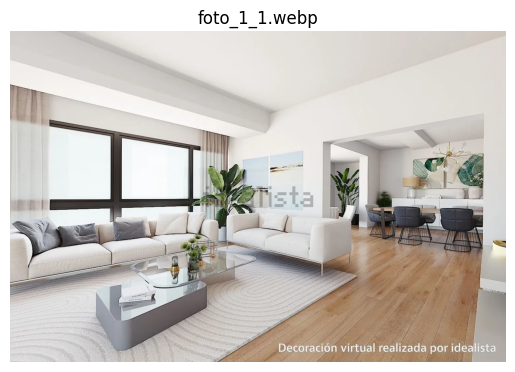

2: foto_1_2.webp


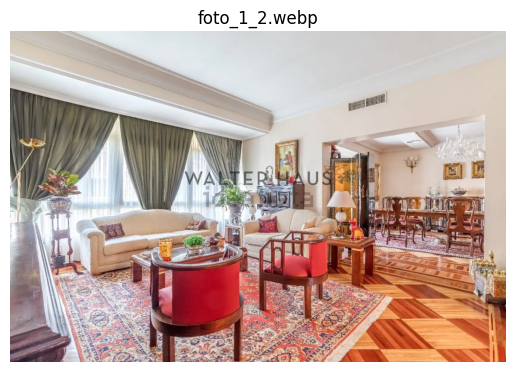

3: foto_1_3.webp


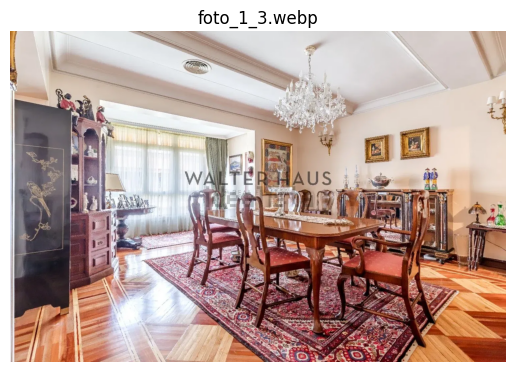

4: foto_1_4.webp


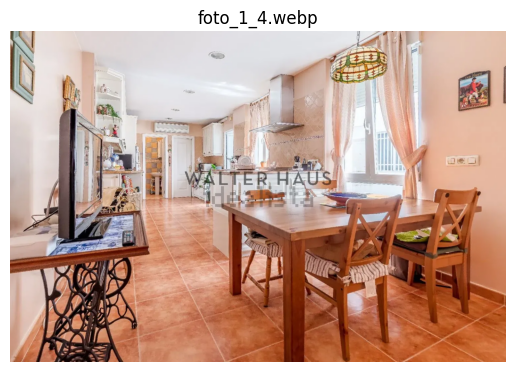

5: foto_1_5.webp


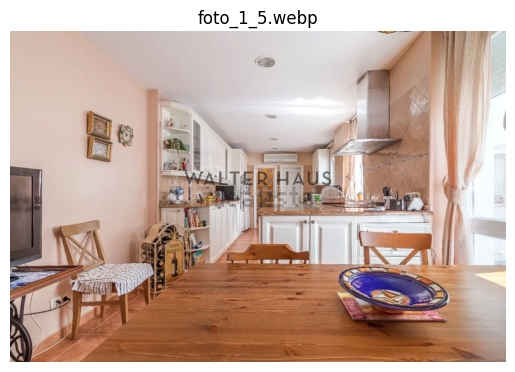

In [ ]:
# Listar todos los archivos en la carpeta especificada
all_files = os.listdir(image_folder_path)

# primera foto
target_files = [f for f in all_files if f.lower().endswith('.webp') and f.lower().startswith('foto_1_')]

# 4 de estos archivos
first_4_target_files = target_files[:5]

print("Listando y mostrando los primeros 4 archivos .webp que empiezan con 'foto_1_':")
for i, filename in enumerate(first_4_target_files):
    #  nombre del archivo
    print(f"{i+1}: {filename}")
    # Construir la ruta completa al archivo de imagen
    image_path = os.path.join(image_folder_path, filename)
    try:

        img = Image.open(image_path)
        plt.imshow(img)
        plt.title(filename)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"No se pudo abrir la imagen {filename}: {e}")

#### Pruebas con midas

In [ ]:
# Cargar el modelo MiDaS
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
midas.to("cuda" if torch.cuda.is_available() else "cpu").eval()

# Transformaciones necesarias
transform = T.Compose([
    T.Resize((384, 384)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:36<00:00, 37.8MB/s]


In [ ]:
def estimate_height(image_path):
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        prediction = midas(input_tensor)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.size[::-1],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()

    # Mostrar imagen + profundidad
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagen original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(depth_map, cmap="inferno")
    plt.title("Mapa de profundidad")
    plt.axis("off")
    plt.show()

    # Heurística de altura relativa suelo-techo (en proporción, no en metros)
    techo = np.percentile(depth_map[:depth_map.shape[0]//5, :], 90)
    suelo = np.percentile(depth_map[-depth_map.shape[0]//5:, :], 10)
    diff = abs(suelo - techo)

    if diff < 0.1:
        return "No aplicable (posible terraza o sin suelo/techo visible)"
    else:
        altura_relativa = diff / depth_map.max()  # valor entre 0 y 1
        return f"Altura detectable (relativa): {altura_relativa:.2f}"

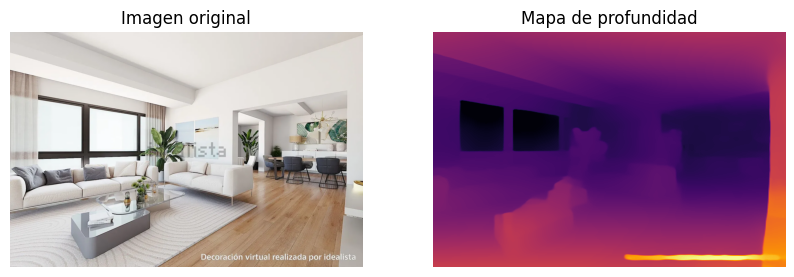

foto_1_1.webp ➜ Altura detectable (relativa): 0.08


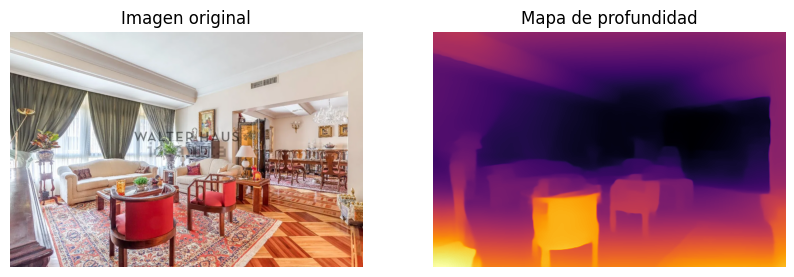

foto_1_2.webp ➜ Altura detectable (relativa): 0.05


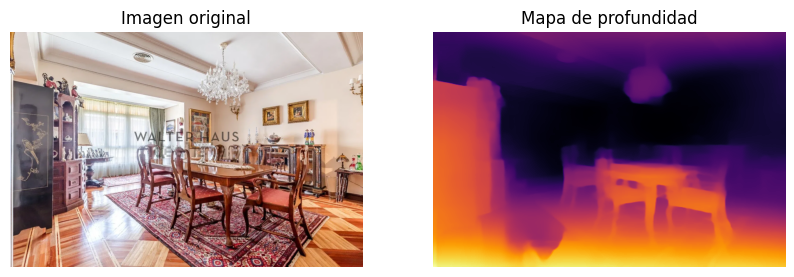

foto_1_3.webp ➜ Altura detectable (relativa): 0.19


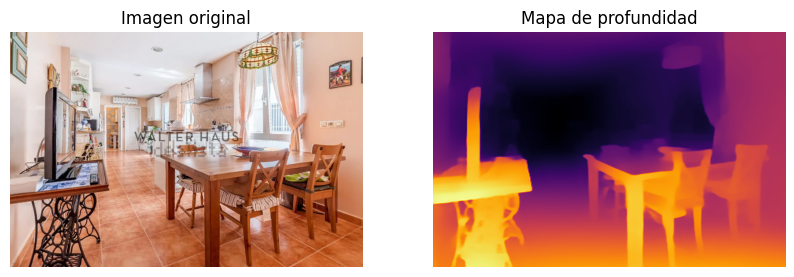

foto_1_4.webp ➜ Altura detectable (relativa): 0.10


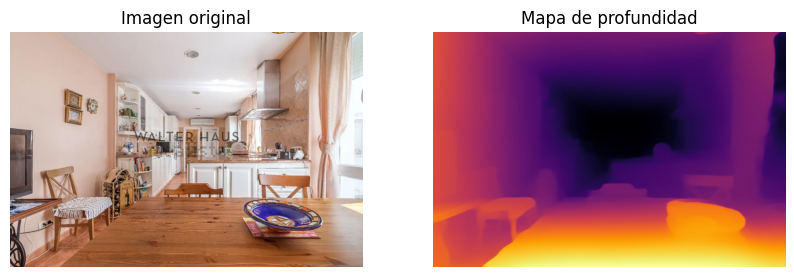

foto_1_5.webp ➜ Altura detectable (relativa): 0.04


In [ ]:
for filename in first_4_target_files:
    image_path = os.path.join(image_folder_path, filename)
    resultado = estimate_height(image_path)
    print(f"{filename} ➜ {resultado}")


#### Pruebas con nuestra clase

In [ ]:
def test_single_property(image_folder_path, property_id):
    """Prueba el algoritmo con una propiedad específica"""
    estimator = SimpleCeilingHeightEstimator()
    result = estimator.analyze_property_images(image_folder_path, property_id)

    print(f"\n=== RESULTADO PARA PROPIEDAD {property_id} ===")
    print(f"Altura estimada: {result['estimated_height']}m")
    print(f"Categoría: {result.get('most_common_category', 'N/A')}")
    print(f"Confianza: {result['confidence']:.2f}")
    print(f"Imágenes analizadas: {result['images_analyzed']}")
    print(f"Desviación entre imágenes: {result.get('height_std', 0):.2f}m")
    print(f"Método: {result['method']}")

    # Mostrar detalles de cada imagen si están disponibles
    if 'individual_results' in result:
        print(f"\nDetalle por imagen:")
        for img_result in result['individual_results']:
            if 'error' not in img_result:
                print(f"  {img_result['filename']}: {img_result['estimated_height']}m "
                      f"({img_result['category']}, conf: {img_result['confidence']:.2f})")

    return result

In [ ]:
# ID de la propiedad que queremos analizar (basado en los nombres de archivo 'foto_1231_...')
property_id_to_test = '0' # Use '1231' as the property ID

# Crear una instancia de la clase SimpleCeilingHeightEstimator
estimator = SimpleCeilingHeightEstimator()

# Llamar a la función analyze_property_images para esta propiedad específica
# Esta función ya maneja la búsqueda de todas las fotos con ese ID en la carpeta
result = estimator.analyze_property_images(image_folder_path, property_id_to_test)

# Imprimir el resultado del análisis para esta propiedad
print(f"\nResultado del análisis de altura para la propiedad {property_id_to_test}:")
print(f"Altura estimada: {result['estimated_height']}m")
print(f"Confianza: {result['confidence']:.2f}")
print(f"Imágenes analizadas: {result['images_analyzed']}")
print(f"Desviación estándar entre imágenes: {result.get('height_std', 0):.2f}m")
print(f"Método principal: {result['method']}")
print(f"Categoría de techo más común: {result.get('most_common_category', 'N/A')}")



Resultado del análisis de altura para la propiedad 0:
Altura estimada: 2.74m
Confianza: 0.75
Imágenes analizadas: 5
Desviación estándar entre imágenes: 0.06m
Método principal: multi_image_median
Categoría de techo más común: medium


## 1.3 Automatización

In [ ]:
# 1. Función para procesar todas las propiedades y asignar alturas al DataFrame
def asignar_alturas_techos(df, image_folder_path_outliers):
    # Crear el estimador
    estimator = SimpleCeilingHeightEstimator()

    # Lista para guardar alturas en el mismo orden que el DataFrame
    alturas_techos = []

    print(f"Procesando {len(df)} propiedades...")

    for idx in df.index:  # Asumimos que el índice coincide con 0...N
        # Obtener todas las imágenes para esta propiedad (foto_X_*.webp)
        image_files = [f for f in os.listdir(image_folder_path_outliers)
                      if f.startswith(f'foto_{idx}_') and f.endswith('.webp')]

        if not image_files:
            print(f"Advertencia: No hay imágenes para propiedad {idx}. Usando valor por defecto (2.7m).")
            alturas_techos.append(2.7)
            continue

        # Procesar imágenes de esta propiedad
        resultados_imagenes = []
        for img_file in image_files:
            img_path = os.path.join(image_folder_path_outliers, img_file)
            try:
                result = estimator.analyze_single_image(img_path)
                resultados_imagenes.append(result['estimated_height'])
            except Exception as e:
                print(f"Error procesando {img_file}: {str(e)}")

        if resultados_imagenes:
            # Usar la MEDIANA de las alturas estimadas (robusta a outliers)
            altura_final = np.median(resultados_imagenes)
            alturas_techos.append(altura_final)
        else:
            alturas_techos.append(2.7)  # Valor por defecto si falla todo

    # Añadir la columna sin modificar el resto del DataFrame
    df = df.copy()
    df['altura_techo'] = alturas_techos

    return df

In [ ]:
df_techos = asignar_alturas_techos(df, image_folder_path)

# 3. Guardar el resultado
df_techos.to_csv('datos_techos.csv', index=False)
print("\nDataset actualizado guardado correctamente.")



Dataset actualizado guardado correctamente.


In [5]:
df_techos = pd.read_csv('/content/drive/MyDrive/CEU SAN PABLO/TFM/datos_alturatecho.csv')

# Laura
#df_techos = pd.read_csv('/content/drive/MyDrive/TFM/datos_alturatecho.csv')


df_techos

address  \
0                            Calle de Zurbano   
1                            Calle de Zurbano   
2                    Calle de Hilarión Eslava   
3                 Calle de Francisco de Rojas   
4     Paseo Walkway de San Francisco de Sales   
...                                       ...   
1156                           Calle de Abtao   
1157                     Calle de Amado Nervo   
1158       Calle del Alcalde Sainz de Baranda   
1159            Calle de Sánchez Barcáiztegui   
1160                         Calle de Máiquez   

                                            agency_name  bathroom_count  \
0                                            Ambassador               4   
1                                    Walter Haus Madrid               4   
2                                    Walter Haus Madrid               5   
3                                    Walter Haus Madrid               3   
4     DIZA Consultores Inmobiliaria - Propiedades de...               3   
...                                                 ...             ...   
1156                                              Huspy               1   
1157                                             Jowner               5   
1158                                              Huspy               2   
1159                                        Servifincas               2   
1160                                   PUBLICASA MADRID               1   

      bedroom_count  floor   latitude  longitude  lot_size  \
0                 5    5.0  40.435694  -3.691642       344   
1                 6    5.0  40.433373  -3.693010       355   
2                 5    2.0  40.435637  -3.716426       265   
3                 3    3.0  40.430204  -3.698828       227   
4                 2    9.0  40.440927  -3.717716       133   
...             ...    ...        ...        ...       ...   
1156              1    4.0  40.404767  -3.677671        51   
1157              6    2.0  40.409615  -3.677602       252   
1158              3    0.0  40.417227  -3.674110       119   
1159              3    1.0  40.407080  -3.673105       107   
1160              3    5.0  40.418837  -3.673959       115   

                                   property_description  \
0     Fantástico tríplex muy luminoso y bien ubicado...   
1     Este exclusivo inmueble, ubicado en el prestig...   
2     Presentamos una espectacular vivienda de lujo,...   
3     Vivienda totalmente reformada y amueblada que ...   
4     DIZA Consultores presenta atico triplex en el ...   
...                                                 ...   
1156  Oportunidad de inversión en El Retiro – Nuda P...   
1157  “JOWNER VENDE DÚPLEX ÚNICO EN PLENO CORAZÓN DE...   
1158  Oportunidad de reforma en el corazón de Ibiza,...   
1159  Si estás buscando un piso de 3 habitaciones an...   
1160  Se aceptan contraofertas! \n\nPublicasa les of...   

                                        property_images  property_price  \
0     ['https://img4.idealista.com/blur/WEB_DETAIL-X...         3300000   
1     ['https://img4.idealista.com/blur/WEB_DETAIL-X...         3300000   
2     ['https://img4.idealista.com/blur/WEB_DETAIL-X...         1975000   
3     ['https://img4.idealista.com/blur/WEB_DETAIL-X...         2200000   
4     ['https://img4.idealista.com/blur/WEB_DETAIL-X...          986210   
...                                                 ...             ...   
1156  ['https://img4.idealista.com/blur/WEB_DETAIL-X...          340000   
1157  ['https://img4.idealista.com/blur/WEB_DETAIL-X...         1835000   
1158  ['https://img4.idealista.com/blur/WEB_DETAIL-X...          955000   
1159  ['https://img4.idealista.com/blur/WEB_DETAIL-X...          670000   
1160  ['https://img4.idealista.com/blur/WEB_DETAIL-X...          895000   

                                         property_title neighborhood  \
0                             Ático en calle de Zurbano     Chamberí   
1     Ático triplex exterior en venta con terraza

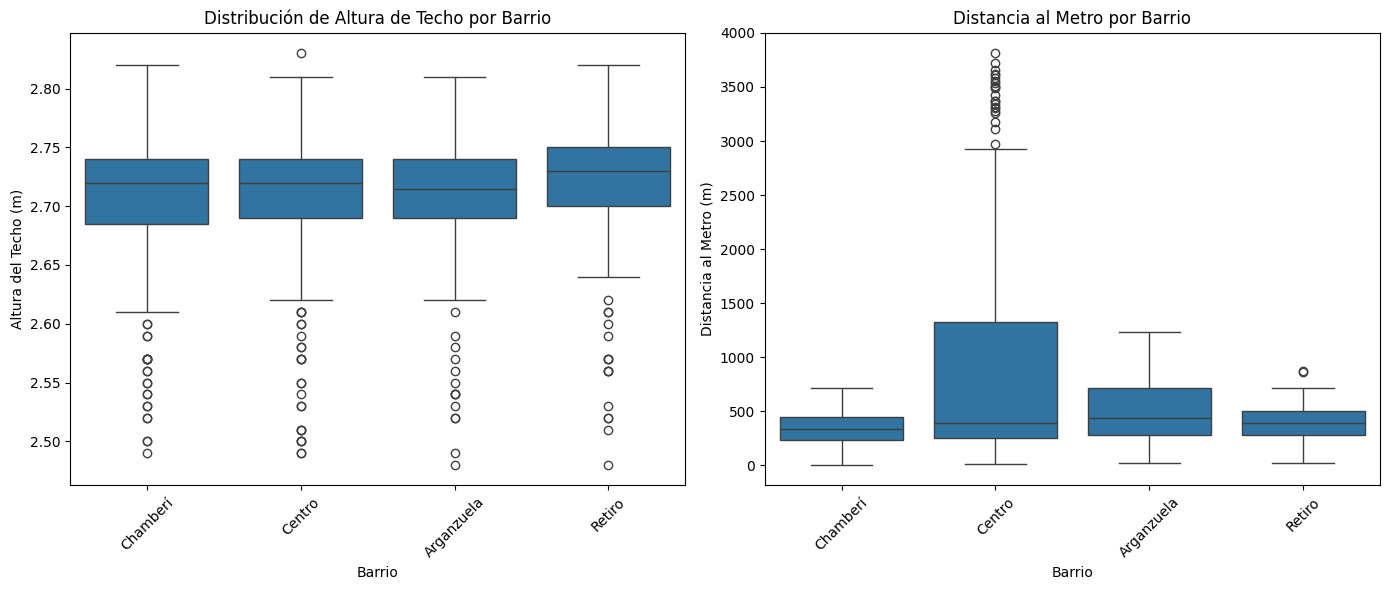

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aumenta el tamaño general de los gráficos
plt.figure(figsize=(14, 6))

# Gráfico 1: Distribución de altura_techo por barrio
plt.subplot(1, 2, 1)
sns.boxplot(data=df_techos, x='neighborhood', y='altura_techo')
plt.xticks(rotation=45)
plt.title('Distribución de Altura de Techo por Barrio')
plt.xlabel('Barrio')
plt.ylabel('Altura del Techo (m)')

# Gráfico 2: Distribución de distancia al metro por barrio
plt.subplot(1, 2, 2)
sns.boxplot(data=df_techos, x='neighborhood', y='dist_metro_m')
plt.xticks(rotation=45)
plt.title('Distancia al Metro por Barrio')
plt.xlabel('Barrio')
plt.ylabel('Distancia al Metro (m)')

plt.tight_layout()
plt.show()


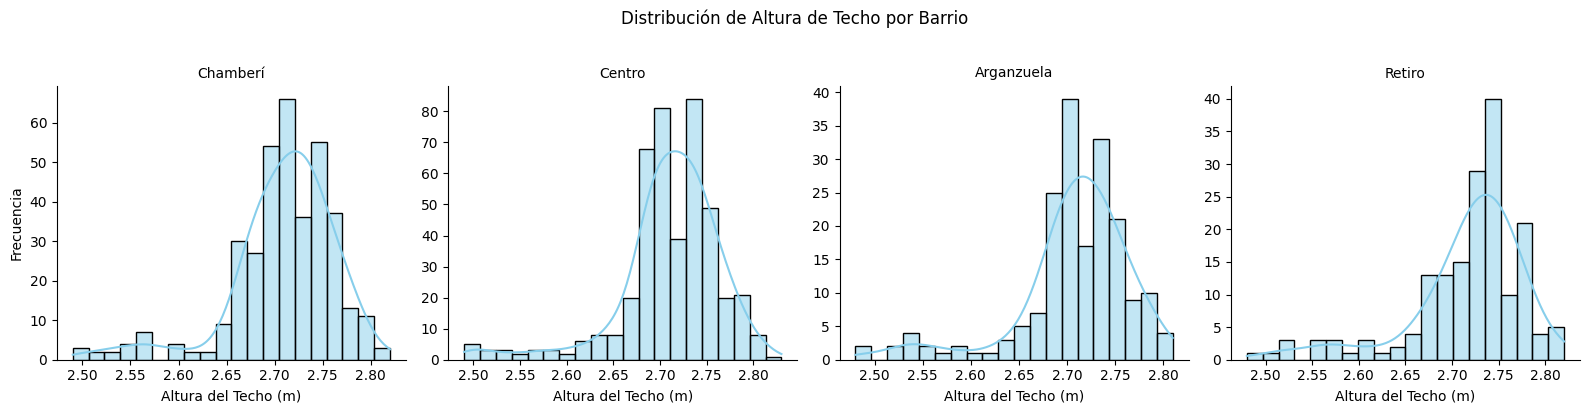

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograma de altura_techo por barrio
g = sns.FacetGrid(df_techos, col='neighborhood', col_wrap=4, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x='altura_techo', bins=20, kde=True, color='skyblue')
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Altura del Techo (m)", "Frecuencia")
g.fig.suptitle('Distribución de Altura de Techo por Barrio', y=1.02)
plt.tight_layout()
plt.show()


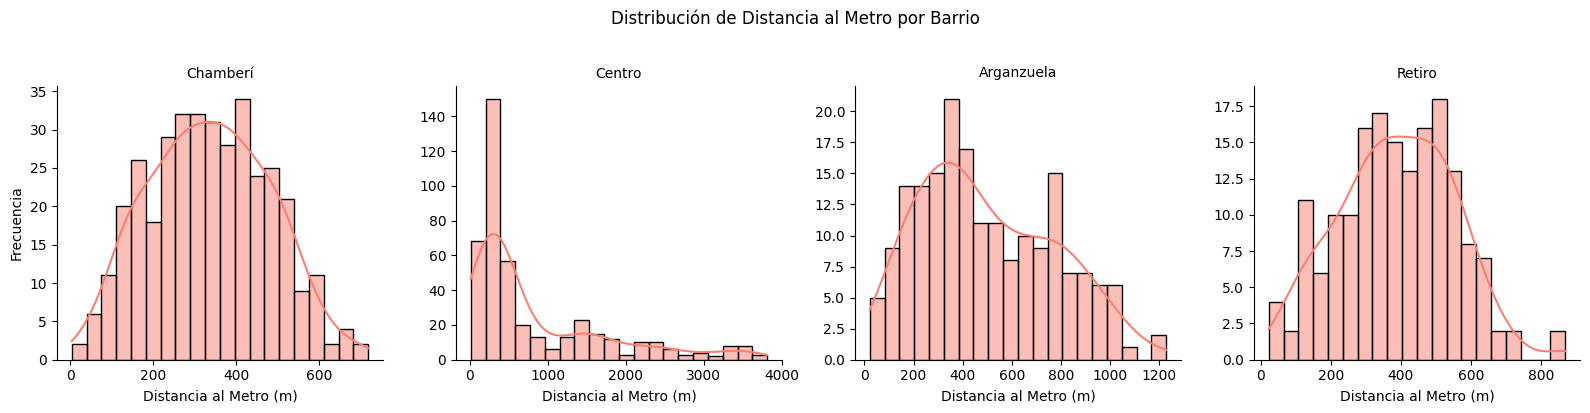

In [8]:
# Histograma de dist_metro por barrio
g = sns.FacetGrid(df_techos, col='neighborhood', col_wrap=4, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x='dist_metro_m', bins=20, kde=True, color='salmon')
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Distancia al Metro (m)", "Frecuencia")
g.fig.suptitle('Distribución de Distancia al Metro por Barrio', y=1.02)
plt.tight_layout()
plt.show()


In [9]:
# 4. Verificación
print(f"\nVerificación:")
print(f"Número de propiedades procesadas: {len(df_techos)}")
print(f"Altura promedio: {df_techos['altura_techo'].mean():.2f}m")
print(f"Ejemplo de alturas asignadas:")
print(df_techos[['neighborhood', 'property_price', 'altura_techo']].head())


Verificación:
Número de propiedades procesadas: 1161
Altura promedio: 2.71m
Ejemplo de alturas asignadas:
  neighborhood  property_price  altura_techo
0     Chamberí         3300000          2.73
1     Chamberí         3300000          2.72
2     Chamberí         1975000          2.75
3     Chamberí         2200000          2.63
4     Chamberí          986210          2.72


In [ ]:
df_techos.to_csv('/content/drive/MyDrive/TFM/datos_alturatecho.csv', index=False)

In [10]:
def info_inicial(df):
    # Mapeo de neighborhoods
    neighborhood_map = {
        1: 'Chamberí',
        2: 'Centro',
        3: 'Arganzuela',
        4: 'Retiro'
    }

    df['neighborhood'] = df['neighborhood'].map(neighborhood_map)

    # Estadísticas de property_price
    precio_promedio = df['property_price'].mean()
    precio_min = df['property_price'].min()
    precio_max = df['property_price'].max()

    # Estadísticas de otros campos
    metros_promedio = df['lot_size'].mean()
    banos_promedio = df['bathroom_count'].mean()
    habitaciones_promedio = df['bedroom_count'].mean()

    # Mostrar resultados
    print(f"Nuḿero de datos:\n{len(df)}")
    print(f"\nPrecio promedio: {precio_promedio/1000:.2f} k€")
    print(f"Precio mínimo: {precio_min/1000:.2f} k€")
    print(f"Precio máximo: {precio_max/1000:.2f} k€")
    print(f"\nPromedio de metros cuadrados: {metros_promedio:.2f} m²")
    print(f"Promedio de baños: {banos_promedio:.2f}")
    print(f"Promedio de habitaciones: {habitaciones_promedio:.2f}")

    return df  # Devuelve el df actualizado con los nombres de barrios

In [11]:
def eliminar_outliers(df):
    df_original = df.copy()
    numeric_cols = df.select_dtypes(include='number').columns

    # Outliers en property_price con IQR
    Q1 = df['property_price'].quantile(0.25)
    Q3 = df['property_price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrado
    df = df[(df['property_price'] >= lower_bound) & (df['property_price'] <= upper_bound)]
    filas_eliminadas = df_original.shape[0] - df.shape[0]

    print(f"\n----Outliers Eliminados ----")
    print(f"Filas eliminadas por outliers en 'property_price': {filas_eliminadas}")

    # Contar outliers en otras columnas numéricas
    print("\nValores atípicos en otras columnas numéricas:")
    for col in numeric_cols:
        if col != 'property_price':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
            print(f" - {col}: {outliers} valores atípicos")

    return df

In [12]:
from pycaret.regression import *

def mejor_modelo_pycaret(df, features):
    print('\n-----Evaluando modelos con pycaret------')

    df_pycaret = df[features + ['property_price']]

    setup(
        data=df_pycaret,
        target='property_price',
        session_id=42,
        train_size=0.8,
        normalize=True,
        verbose=False
    )

    # Añade verbose=False para evitar salida innecesaria
    best_model_pycaret = compare_models(sort='RMSE', verbose=False)

    # Usamos pull para capturar la tabla sin mostrarla
    resultados = pull();  # El punto y coma evita que Jupyter la muestre

    mejor_fila = resultados.loc[resultados['RMSE'].idxmin()]
    nombre_modelo = mejor_fila['Model']
    rmse = mejor_fila['RMSE']

    precio_medio = df['property_price'].mean()
    error_porcentual = (rmse / precio_medio) * 100

    print("=== Mejor Modelo ===")
    print(f"Modelo: {nombre_modelo}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Error porcentual sobre precio promedio: {error_porcentual:.2f}%")

    return best_model_pycaret

In [13]:
from pycaret.regression import plot_model
import matplotlib.pyplot as plt

def visualizaciones_modelo(df, modelo):
    print("\nVisualizaciones del modelo:")

    # Guardar los gráficos en archivos temporales
    plot_model(modelo, plot='feature', save=True)
    plot_model(modelo, plot='residuals', save=True)
    plot_model(modelo, plot='error', save=True)

    # Los archivos generados se llaman:
    # 'Feature Importance.png', 'Residuals.png', 'Prediction Error.png'
    # (o similar, depende versión PyCaret y plot)

    img1 = plt.imread('Feature Importance.png')
    img2 = plt.imread('Residuals.png')
    img3 = plt.imread('Prediction Error.png')

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('Importancia Variables')

    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('Residuos')

    axes[2].imshow(img3)
    axes[2].axis('off')
    axes[2].set_title('Predicciones vs Reales')

    plt.tight_layout()
    plt.show()


================= Análisis para CHAMBERÍ =================
----- Info preliminar -----
Nuḿero de datos:
367

Precio promedio: 1329.55 k€
Precio mínimo: 250.00 k€
Precio máximo: 3500.00 k€

Promedio de metros cuadrados: 150.37 m²
Promedio de baños: 2.36
Promedio de habitaciones: 2.95

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 19

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 0 valores atípicos
 - bedroom_count: 1 valores atípicos
 - floor: 3 valores atípicos
 - latitude: 0 valores atípicos
 - longitude: 0 valores atípicos
 - lot_size: 6 valores atípicos
 - exterior: 70 valores atípicos
 - ascensor: 22 valores atípicos
 - dist_metro_m: 0 valores atípicos
 - energy_certificate_encoded: 35 valores atípicos
 - altura_techo: 25 valores atípicos

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Extra Trees Regressor
RMSE: 227286.26
Error porcentual sobre precio promedio: 18.62%

Visualizaciones del modelo:


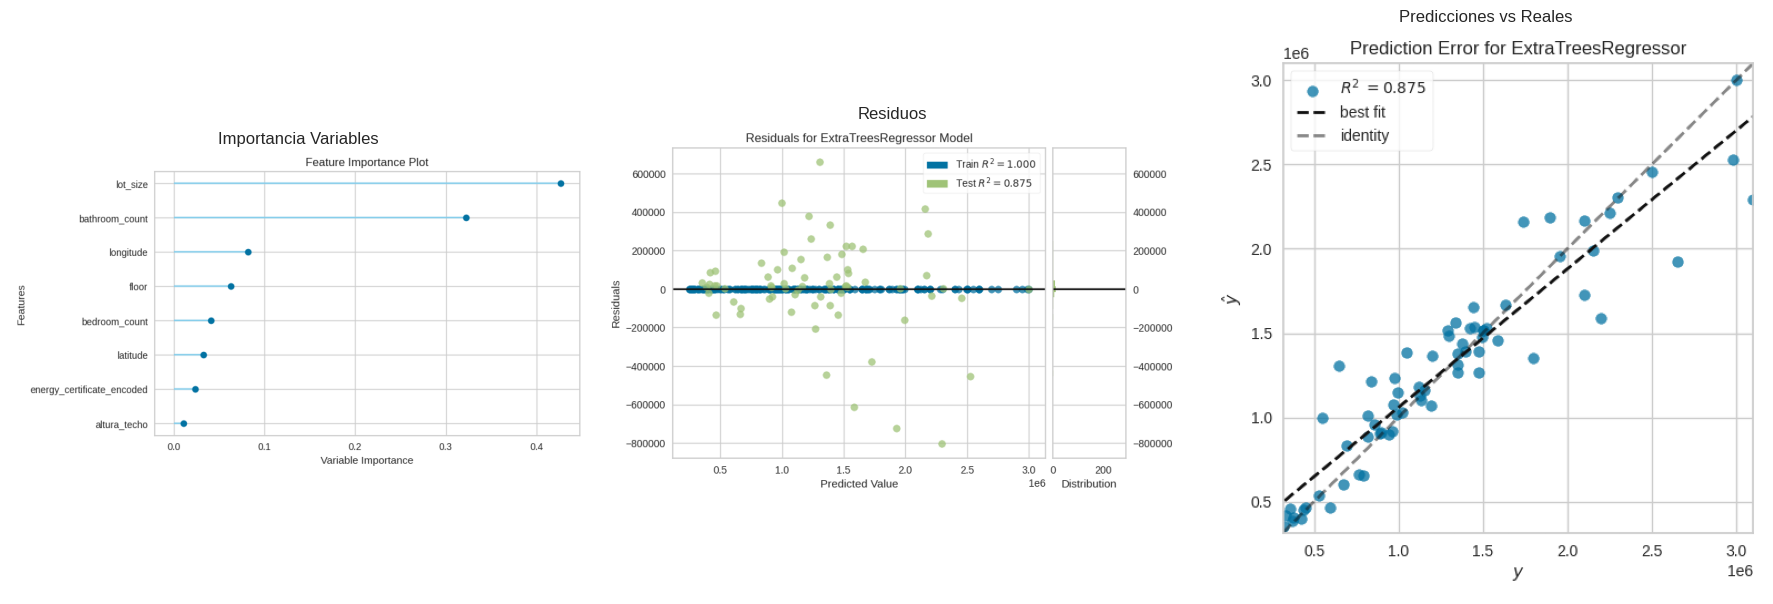


================= Análisis para CENTRO =================
----- Info preliminar -----
Nuḿero de datos:
434

Precio promedio: 1495.12 k€
Precio mínimo: 220.00 k€
Precio máximo: 4300.00 k€

Promedio de metros cuadrados: 255.10 m²
Promedio de baños: 3.17
Promedio de habitaciones: 3.62

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 6

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 18 valores atípicos
 - bedroom_count: 11 valores atípicos
 - floor: 12 valores atípicos
 - latitude: 0 valores atípicos
 - longitude: 0 valores atípicos
 - lot_size: 49 valores atípicos
 - exterior: 48 valores atípicos
 - ascensor: 57 valores atípicos
 - dist_metro_m: 28 valores atípicos
 - energy_certificate_encoded: 0 valores atípicos
 - altura_techo: 25 valores atípicos

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Gradient Boosting Regressor
RMSE: 371234.84
Error porcentual sobre precio promedio: 25.48%

Visualizaciones del modelo:


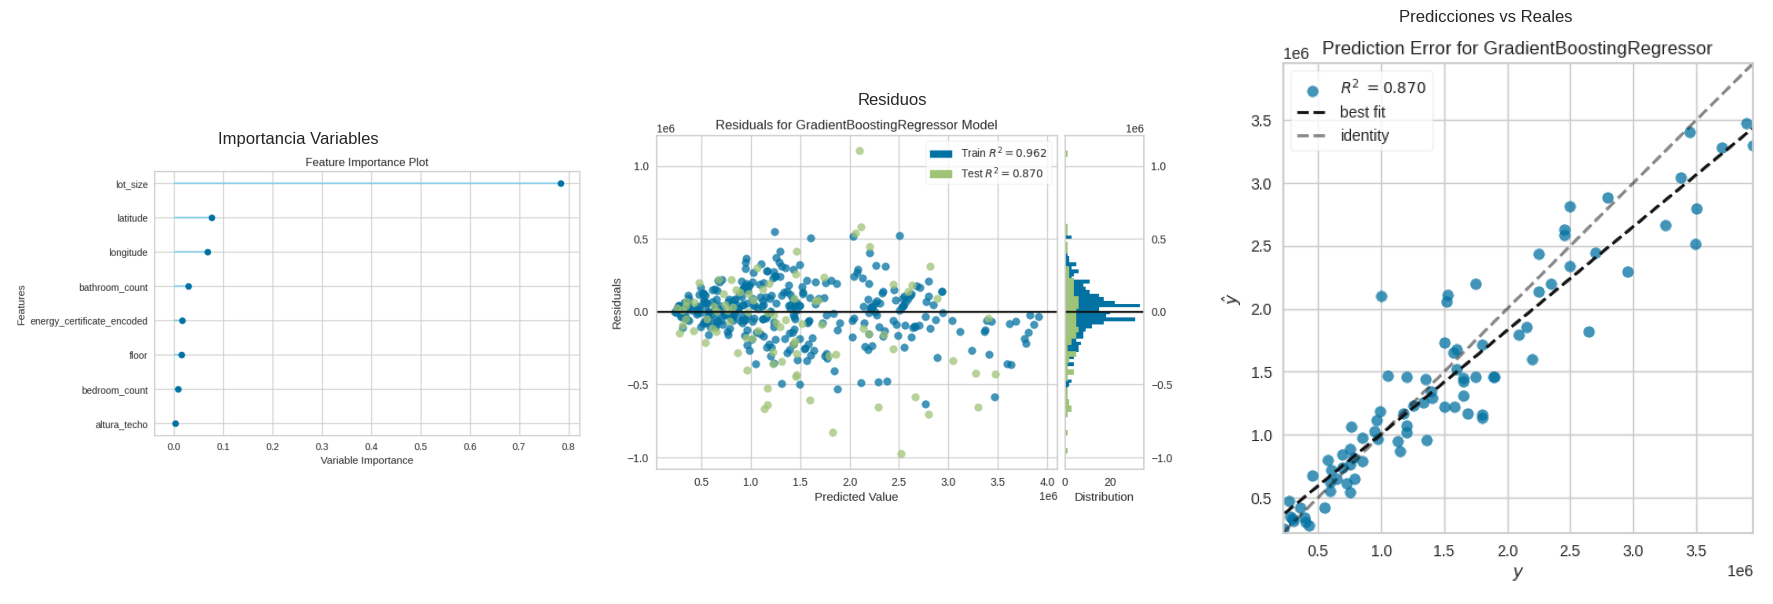


================= Análisis para ARGANZUELA =================
----- Info preliminar -----
Nuḿero de datos:
188

Precio promedio: 475.62 k€
Precio mínimo: 85.40 k€
Precio máximo: 970.00 k€

Promedio de metros cuadrados: 83.26 m²
Promedio de baños: 1.39
Promedio de habitaciones: 2.39

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 0

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 0 valores atípicos
 - bedroom_count: 0 valores atípicos
 - floor: 0 valores atípicos
 - latitude: 1 valores atípicos
 - longitude: 0 valores atípicos
 - lot_size: 0 valores atípicos
 - exterior: 0 valores atípicos
 - ascensor: 22 valores atípicos
 - dist_metro_m: 0 valores atípicos
 - energy_certificate_encoded: 28 valores atípicos
 - altura_techo: 14 valores atípicos

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Extra Trees Regressor
RMSE: 71478.63
Error porcentual sobre precio promedio: 15.03%

Visualizaciones del modelo:


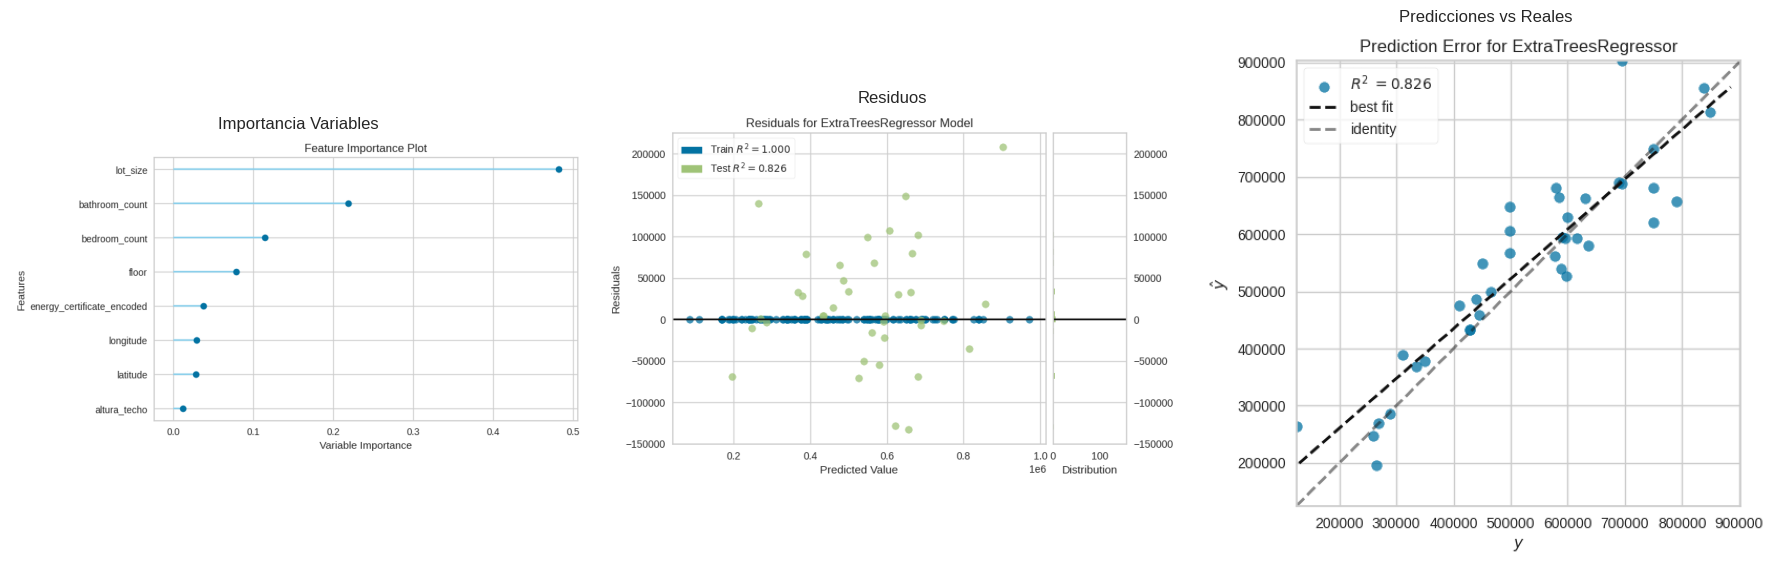


================= Análisis para RETIRO =================
----- Info preliminar -----
Nuḿero de datos:
172

Precio promedio: 916.17 k€
Precio mínimo: 260.00 k€
Precio máximo: 2150.00 k€

Promedio de metros cuadrados: 114.25 m²
Promedio de baños: 1.91
Promedio de habitaciones: 2.72

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 5

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 4 valores atípicos
 - bedroom_count: 8 valores atípicos
 - floor: 1 valores atípicos
 - latitude: 0 valores atípicos
 - longitude: 6 valores atípicos
 - lot_size: 4 valores atípicos
 - exterior: 0 valores atípicos
 - ascensor: 12 valores atípicos
 - dist_metro_m: 1 valores atípicos
 - energy_certificate_encoded: 28 valores atípicos
 - altura_techo: 16 valores atípicos

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Extra Trees Regressor
RMSE: 170161.99
Error porcentual sobre precio promedio: 19.29%

Visualizaciones del modelo:


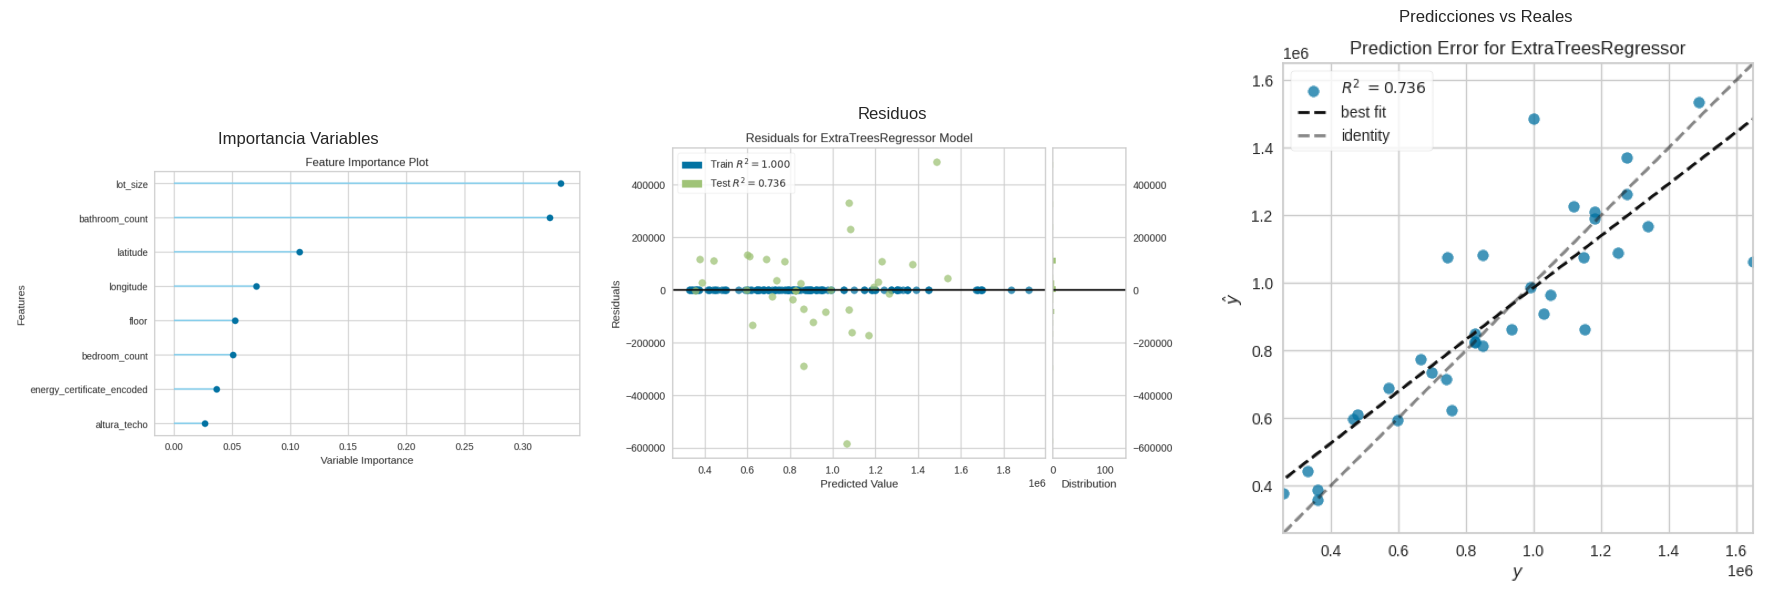

In [17]:

neighborhood_dict = {
    1: 'Chamberí',
    2: 'Centro',
    3: 'Arganzuela',
    4: 'Retiro'
}

features = ['bathroom_count',
 'bedroom_count',
 'energy_certificate_encoded',
 'floor',
 'lot_size', 'longitude','latitude','altura_techo']

# Crear una lista para almacenar los DataFrames procesados de cada barrio
df_procesados = []

for codigo, nombre in neighborhood_dict.items():
    print(f"\n================= Análisis para {nombre.upper()} =================")

    # 1. Subset del dataset original
    print('----- Info preliminar -----')
    df_barrio = df_techos[df_techos['neighborhood'] == nombre].copy()

    # 2. Info inicial
    info_inicial(df_barrio)

    # 3. Eliminar outliers
    df_barrio = eliminar_outliers(df_barrio)
    # 4. Transformaciones

    # Agregar el DataFrame procesado a la lista
    df_procesados.append(df_barrio)

    # 5. Modelo con PyCaret
    modelo = mejor_modelo_pycaret(df_barrio, features)

    # 6. Visualizaciones
    visualizaciones_modelo(df_barrio, modelo)

# Combinar todos los DataFrames procesados en uno solo
df_final = pd.concat(df_procesados, ignore_index=True)



================= Análisis para CHAMBERÍ =================
----- Info preliminar -----
Nuḿero de datos:
367

Precio promedio: 1329.55 k€
Precio mínimo: 250.00 k€
Precio máximo: 3500.00 k€

Promedio de metros cuadrados: 150.37 m²
Promedio de baños: 2.36
Promedio de habitaciones: 2.95

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 19

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 0 valores atípicos
 - bedroom_count: 1 valores atípicos
 - floor: 3 valores atípicos
 - latitude: 0 valores atípicos
 - longitude: 0 valores atípicos
 - lot_size: 6 valores atípicos
 - exterior: 70 valores atípicos
 - ascensor: 22 valores atípicos
 - dist_metro_m: 0 valores atípicos
 - energy_certificate_encoded: 35 valores atípicos
 - altura_techo: 25 valores atípicos

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Extra Trees Regressor
RMSE: 221905.34
Error porcentual sobre precio promedio: 18.18%
R-squared: 0.88

Visualizaciones del 

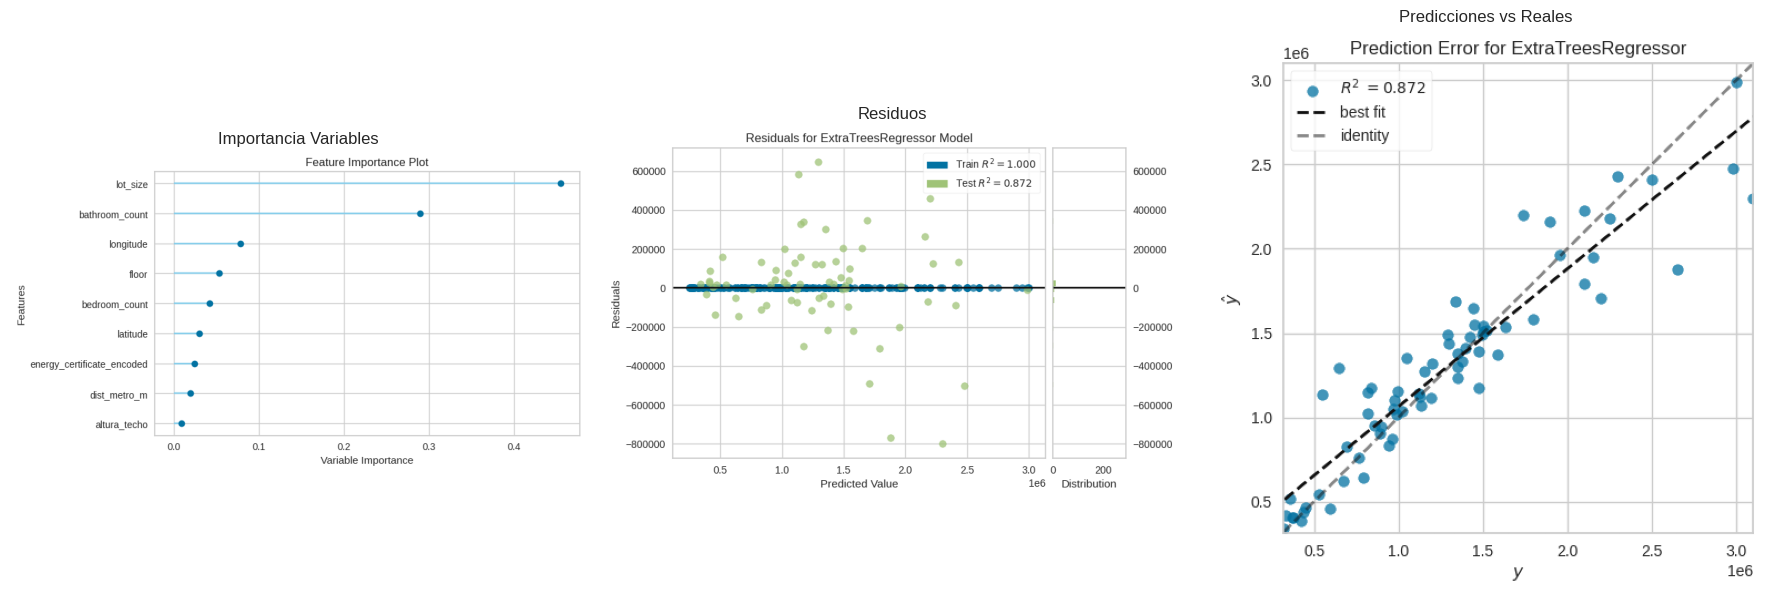


================= Análisis para CENTRO =================
----- Info preliminar -----
Nuḿero de datos:
434

Precio promedio: 1495.12 k€
Precio mínimo: 220.00 k€
Precio máximo: 4300.00 k€

Promedio de metros cuadrados: 255.10 m²
Promedio de baños: 3.17
Promedio de habitaciones: 3.62

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 6

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 18 valores atípicos
 - bedroom_count: 11 valores atípicos
 - floor: 12 valores atípicos
 - latitude: 0 valores atípicos
 - longitude: 0 valores atípicos
 - lot_size: 49 valores atípicos
 - exterior: 48 valores atípicos
 - ascensor: 57 valores atípicos
 - dist_metro_m: 28 valores atípicos
 - energy_certificate_encoded: 0 valores atípicos
 - altura_techo: 25 valores atípicos

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Extra Trees Regressor
RMSE: 368094.49
Error porcentual sobre precio promedio: 25.26%
R-squared: 0.82

Visualizaciones del

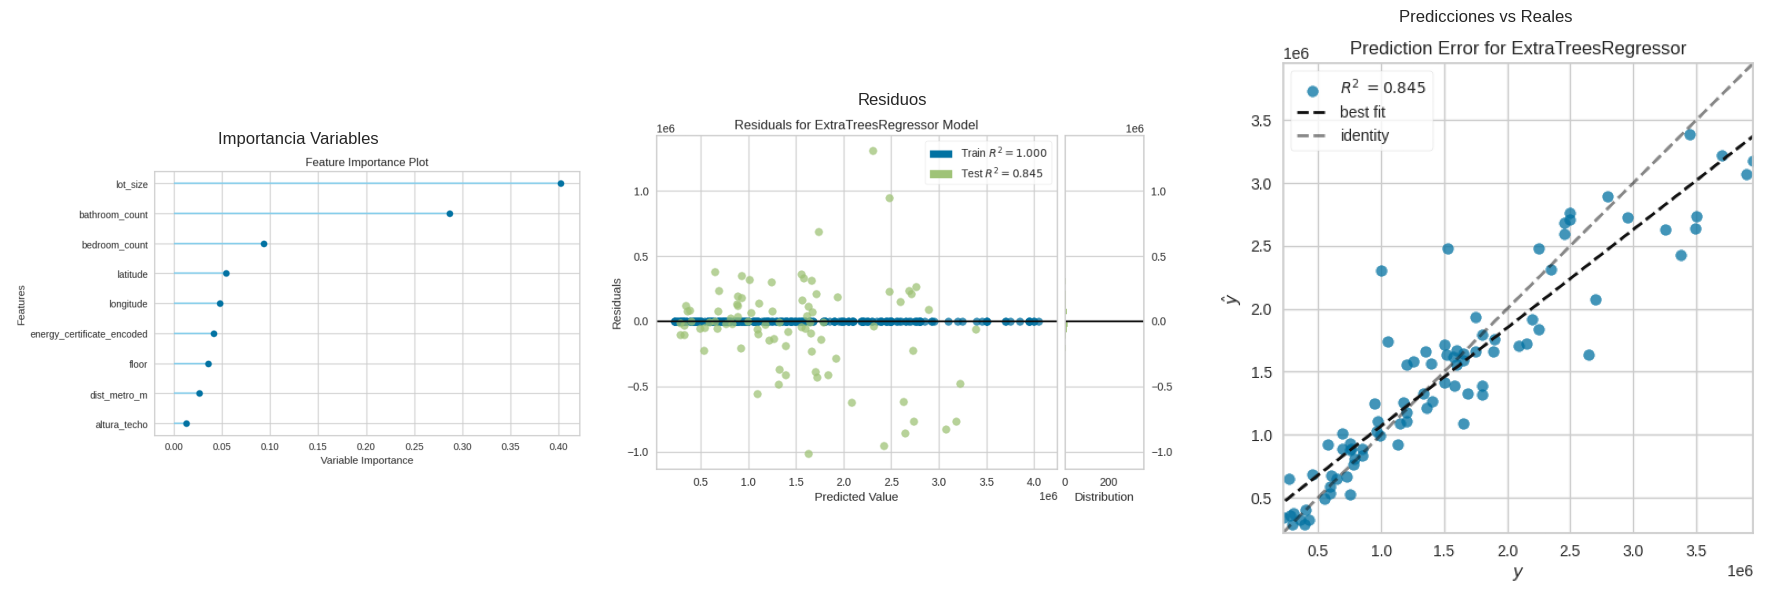


================= Análisis para ARGANZUELA =================
----- Info preliminar -----
Nuḿero de datos:
188

Precio promedio: 475.62 k€
Precio mínimo: 85.40 k€
Precio máximo: 970.00 k€

Promedio de metros cuadrados: 83.26 m²
Promedio de baños: 1.39
Promedio de habitaciones: 2.39

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 0

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 0 valores atípicos
 - bedroom_count: 0 valores atípicos
 - floor: 0 valores atípicos
 - latitude: 1 valores atípicos
 - longitude: 0 valores atípicos
 - lot_size: 0 valores atípicos
 - exterior: 0 valores atípicos
 - ascensor: 22 valores atípicos
 - dist_metro_m: 0 valores atípicos
 - energy_certificate_encoded: 28 valores atípicos
 - altura_techo: 14 valores atípicos

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Extra Trees Regressor
RMSE: 69956.17
Error porcentual sobre precio promedio: 14.71%
R-squared: 0.83

Visualizaciones del model

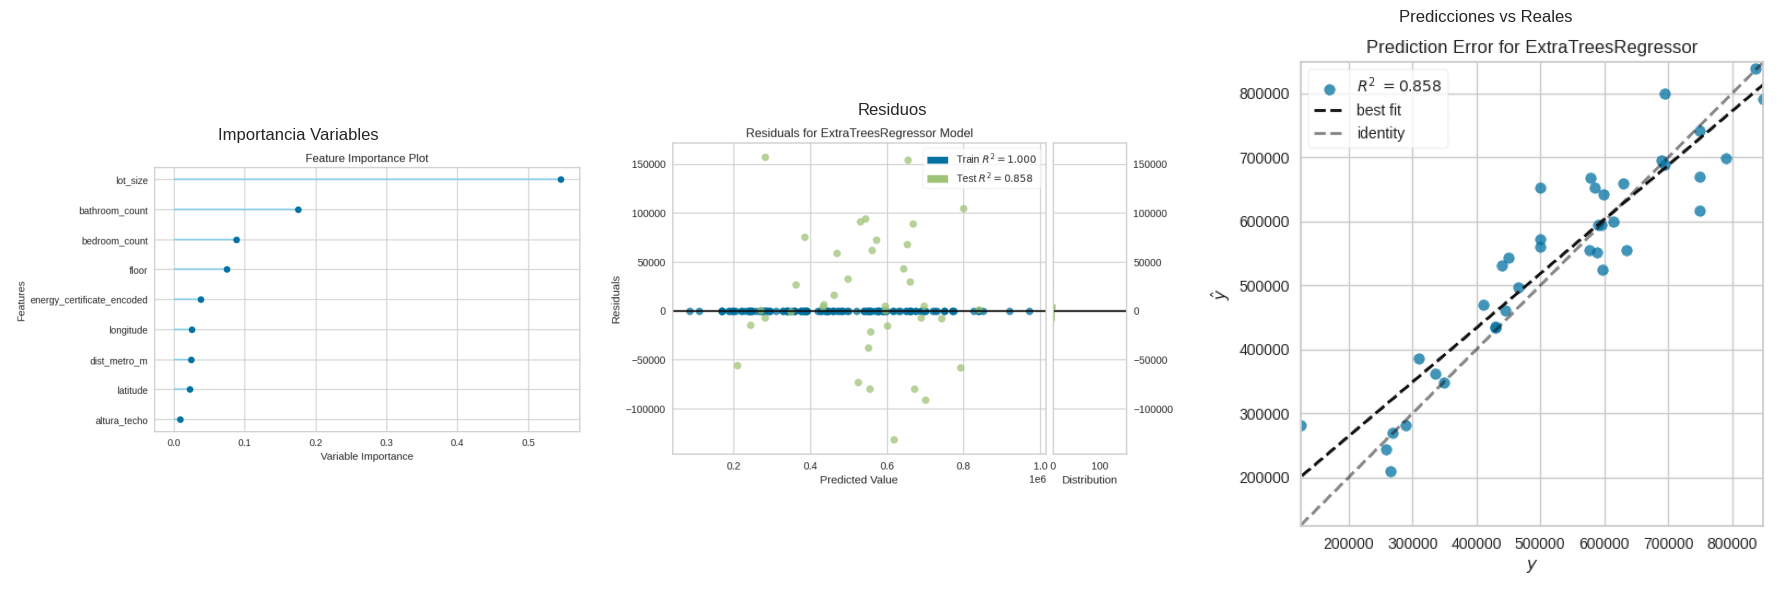


================= Análisis para RETIRO =================
----- Info preliminar -----
Nuḿero de datos:
172

Precio promedio: 916.17 k€
Precio mínimo: 260.00 k€
Precio máximo: 2150.00 k€

Promedio de metros cuadrados: 114.25 m²
Promedio de baños: 1.91
Promedio de habitaciones: 2.72

----Outliers Eliminados ----
Filas eliminadas por outliers en 'property_price': 5

Valores atípicos en otras columnas numéricas:
 - bathroom_count: 4 valores atípicos
 - bedroom_count: 8 valores atípicos
 - floor: 1 valores atípicos
 - latitude: 0 valores atípicos
 - longitude: 6 valores atípicos
 - lot_size: 4 valores atípicos
 - exterior: 0 valores atípicos
 - ascensor: 12 valores atípicos
 - dist_metro_m: 1 valores atípicos
 - energy_certificate_encoded: 28 valores atípicos
 - altura_techo: 16 valores atípicos

-----Evaluando modelos con pycaret------
=== Mejor Modelo ===
Modelo: Extra Trees Regressor
RMSE: 170681.49
Error porcentual sobre precio promedio: 19.35%
R-squared: 0.70

Visualizaciones del model

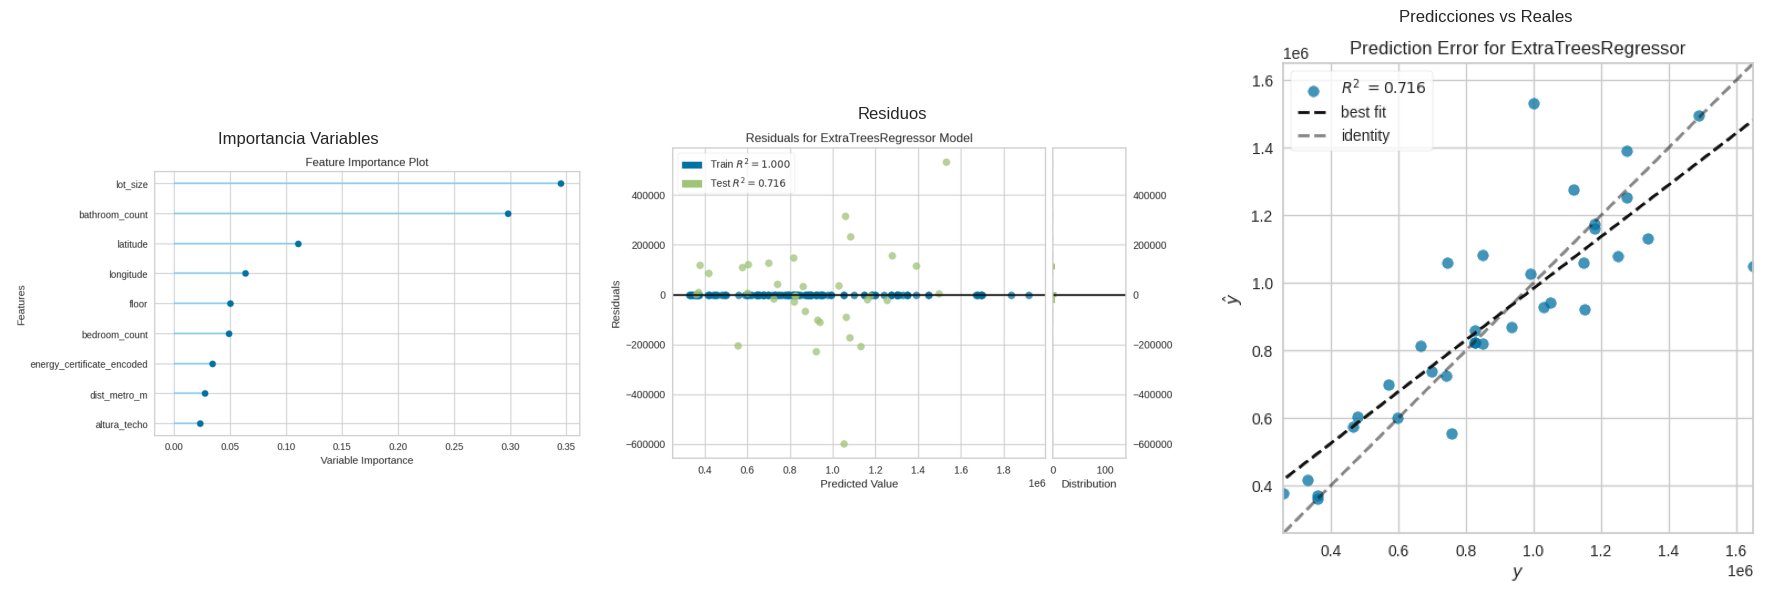

In [19]:
neighborhood_dict = {
    1: 'Chamberí',
    2: 'Centro',
    3: 'Arganzuela',
    4: 'Retiro'
}

features = ['bathroom_count',
 'bedroom_count',
 'energy_certificate_encoded',
 'floor',
 'lot_size', 'longitude','latitude','altura_techo', 'dist_metro_m']

# Crear una lista para almacenar los DataFrames procesados de cada barrio
df_procesados = []

for codigo, nombre in neighborhood_dict.items():
    print(f"\n================= Análisis para {nombre.upper()} =================")

    # 1. Subset del dataset original
    print('----- Info preliminar -----')
    df_barrio = df_techos[df_techos['neighborhood'] == nombre].copy()

    # 2. Info inicial
    info_inicial(df_barrio)

    # 3. Eliminar outliers
    df_barrio = eliminar_outliers(df_barrio)
    # 4. Transformaciones

    # Agregar el DataFrame procesado a la lista
    df_procesados.append(df_barrio)

    # 5. Modelo con PyCaret
    modelo = mejor_modelo_pycaret(df_barrio, features)

    # Get the R-squared value from the results
    resultados = pull()
    mejor_fila = resultados.loc[resultados['RMSE'].idxmin()]
    r_squared = mejor_fila['R2']

    print(f"R-squared: {r_squared:.2f}")


    # 6. Visualizaciones
    visualizaciones_modelo(df_barrio, modelo)

# Combinar todos los DataFrames procesados en uno solo
df_final = pd.concat(df_procesados, ignore_index=True)

In [ ]:
print(features)

['bathroom_count', 'bedroom_count', 'energy_certificate_encoded', 'floor', 'neighborhood', 'lot_size', 'longitude', 'latitude', 'altura_techo']


In [ ]:

print(df_barrio.columns)


Index(['address', 'agency_name', 'bathroom_count', 'bedroom_count', 'floor',
       'latitude', 'longitude', 'lot_size', 'property_description',
       'property_images', 'property_price', 'property_title', 'neighborhood',
       'exterior', 'ascensor', 'dist_metro_m', 'property_type_flat',
       'energy_certificate_encoded', 'property_type_chalet', 'altura_techo'],
      dtype='object')
